In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
BUFFER_SIZE=10000
BATCH_SIZE=32
IMG_SIZE=(32,32)

train_data = tf.keras.preprocessing.image_dataset_from_directory('/kaggle/input',
                                                                 validation_split=.9,
                                                                 subset='training',
                                                                 seed=123,
                                                                 image_size=IMG_SIZE,
                                                                 batch_size=BATCH_SIZE,
                                                                 color_mode='grayscale',
                                                                 shuffle=True)
val_data = tf.keras.preprocessing.image_dataset_from_directory('/kaggle/input',
                                                               validation_split=.9,
                                                               subset='validation',
                                                               seed=123,
                                                               image_size=IMG_SIZE,
                                                               batch_size=BATCH_SIZE,
                                                               color_mode='grayscale')

#train_data = train_data.map(lambda img, lab: tf.image.resize(img, IMG_SIZE))
#val_data = val_data.map(lambda img, lab: tf.image.resize(img, IMG_SIZE))

#train_data = train_data.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
#val_data = val_data.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

Found 25663 files belonging to 1 classes.
Using 2567 files for training.
Found 25663 files belonging to 1 classes.
Using 23096 files for validation.


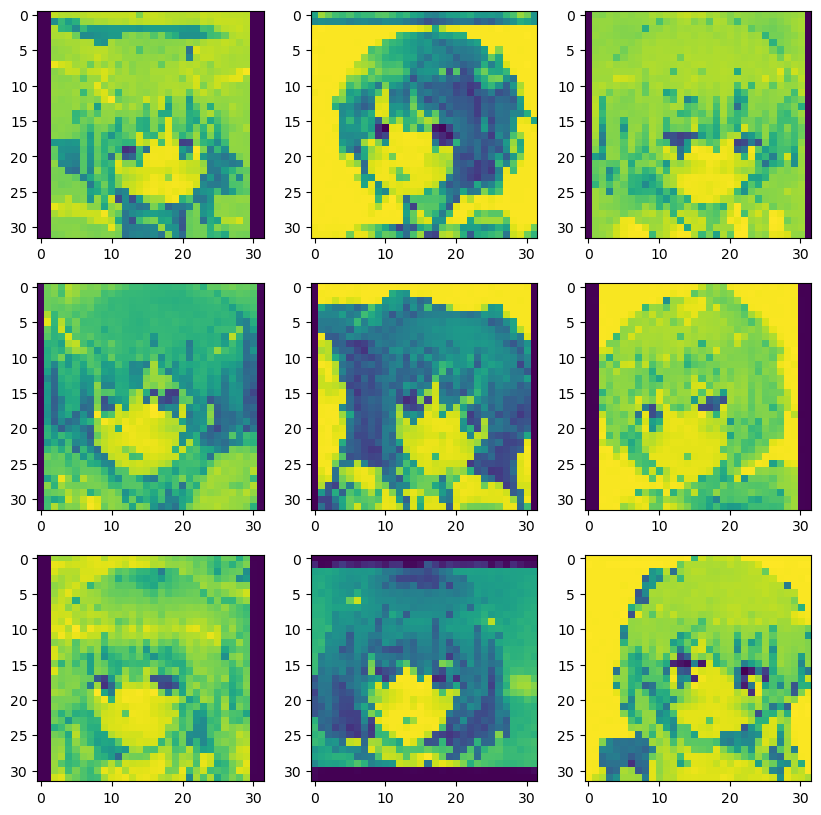

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for img, lab in train_data.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(img[i].numpy().astype('uint8'))

In [4]:
from tensorflow.keras import layers

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(4*4*32, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((4, 4, 32)))
    assert model.output_shape == (None, 4, 4, 32)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(32, (2, 2), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 4, 4, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 16)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 8)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (2, 2), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 32, 32, 1)

    return model

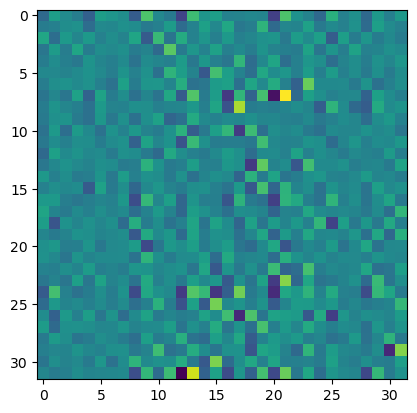

In [5]:
generator = make_generator_model()
noise = tf.random.normal([1,100])
gen_img = generator(noise, training=False)
plt.imshow(gen_img[0,:,:,0])

In [6]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (10, 10), strides=(2, 2), padding='same',
                                     input_shape=[32, 32, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (10, 10), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [7]:
discriminator = make_discriminator_model()
decision = discriminator(gen_img)
print(decision)

tf.Tensor([[0.00154424]], shape=(1, 1), dtype=float32)


In [8]:
def discriminator_loss(real_output, fake_output):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(real_output), real_output)
    fake_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(fake_output), fake_output)

gen_opt = tf.keras.optimizers.Adam(1e-4)
disc_opt = tf.keras.optimizers.Adam(1e-4)

In [9]:
checkpoint_dir = '/kaggle/working/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=gen_opt,
                                 discriminator_optimizer=disc_opt,
                                 generator=generator,
                                 discriminator=discriminator)

In [10]:
EPOCHS=50
noise_dim=100
num_examples=16

seed = tf.random.normal([num_examples, noise_dim])

In [11]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_imgs = generator(noise, training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(gen_imgs, training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
    gen_grads = gen_tape.gradient(gen_loss, generator.trainable_variables)
    disc_grads = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gen_opt.apply_gradients(zip(gen_grads, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_grads, discriminator.trainable_variables))
    
    

In [12]:
def train(dataset, epochs):
    num_batches = dataset.cardinality().numpy()
    
    for epoch in range(epochs):
        print("EPOCH ", epoch)
        step = 1
        
        for image_batch, labs in dataset:
            print("Step ", step, " of ", num_batches)
            train_step(image_batch)
            step += 1
            
        if (epoch+1) % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

In [13]:
train(train_data, EPOCHS)

EPOCH  0
Step  1  of  81
Step  2  of  81
Step  3  of  81
Step  4  of  81
Step  5  of  81
Step  6  of  81
Step  7  of  81
Step  8  of  81
Step  9  of  81
Step  10  of  81
Step  11  of  81
Step  12  of  81
Step  13  of  81
Step  14  of  81
Step  15  of  81
Step  16  of  81
Step  17  of  81
Step  18  of  81
Step  19  of  81
Step  20  of  81
Step  21  of  81
Step  22  of  81
Step  23  of  81
Step  24  of  81
Step  25  of  81
Step  26  of  81
Step  27  of  81
Step  28  of  81
Step  29  of  81
Step  30  of  81
Step  31  of  81
Step  32  of  81
Step  33  of  81
Step  34  of  81
Step  35  of  81
Step  36  of  81
Step  37  of  81
Step  38  of  81
Step  39  of  81
Step  40  of  81
Step  41  of  81
Step  42  of  81
Step  43  of  81
Step  44  of  81
Step  45  of  81
Step  46  of  81
Step  47  of  81
Step  48  of  81
Step  49  of  81
Step  50  of  81
Step  51  of  81
Step  52  of  81
Step  53  of  81
Step  54  of  81
Step  55  of  81
Step  56  of  81
Step  57  of  81
Step  58  of  81
Step  59  of  

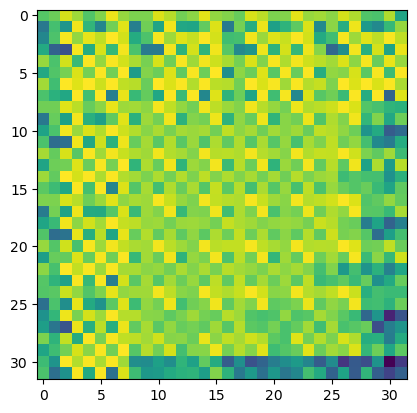

In [14]:
noise = tf.random.normal([1,100])
gen_img = generator(noise, training=False)
plt.imshow(gen_img[0,:,:,0])